In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
import talib as ta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')

def generate_dollar_bars(trades_df, target_hour=1):
    """生成近似目标小时级的Dollar Bar"""
    # 计算小时级平均成交额作为阈值
    hourly_volume = trades_df.resample(f'{target_hour}H', on='trade_time')['dollar_amount'].sum()
    dollar_threshold = hourly_volume.mean()  # 阈值=目标小时级平均成交额
    
    # 生成Bar
    trades_df['cum_dollar'] = trades_df['dollar_amount'].cumsum()
    trades_df['bar_id'] = (trades_df['cum_dollar'] // dollar_threshold).astype(int)
    
    # 过滤不完整的最后一个Bar
    last_valid_id = trades_df['bar_id'].max() - 1
    trades_df = trades_df[trades_df['bar_id'] <= last_valid_id]
    
    # 提取每个Bar的时间区间和基础统计量
    bar_info = trades_df.groupby('bar_id').agg(
        start_time=('trade_time', 'min'),
        end_time=('trade_time', 'max'),
        total_dollar=('dollar_amount', 'sum'),
        price_open=('price', 'first'),
        price_close=('price', 'last'),
        price_high=('price', 'max'),
        price_low=('price', 'min'),
        trade_count=('price', 'count')
    ).reset_index()
    
    # 计算Bar的未来收益（预测目标：下一个Bar的涨跌幅）
    bar_info['future_return'] = (bar_info['price_close'].shift(-1) - bar_info['price_close']) / bar_info['price_close'] * 100
    
    return trades_df, bar_info, dollar_threshold

def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    trades['time'] = _ensure_datetime(trades['time'])
    trades = trades.sort_values('time').reset_index(drop=True)
    df = trades.copy()
    # 处理时间列和排序
    # df['time'] = _ensure_datetime(df['time'])
    # df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 核心改进：逐笔计算bar_id，确保连续递增
    cumulative = 0.0  # 累积成交额
    bar_id = 0        # 当前bar_id
    bar_ids = []      # 存储每个交易的bar_id
    
    for qty in df['quote_qty']:
        cumulative += qty
        # 当累积成交额达到阈值时，当前交易仍属于当前bar_id，随后bar_id递增并重置累积
        if cumulative >= dollar_threshold:
            bar_ids.append(bar_id)
            # 重置累积（保留超额部分，用于下一个bar的计算）
            cumulative -= dollar_threshold
            bar_id += 1
        else:
            bar_ids.append(bar_id)
    
    df['bar_id'] = bar_ids
    
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
    }
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume'
    ]
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g
 


def _add_bar_lags_and_rollings(
    Xb: pd.DataFrame,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> pd.DataFrame:
    X = Xb.copy().sort_index()

    feature_cols = list(X.columns)

    # lags
    for k in range(1, add_lags + 1):
        for col in feature_cols:
            X[f'{col}_lag{k}'] = X[col].shift(k)

    # rollings
    if rolling_windows:
        stats = rolling_stats or ['mean', 'std', 'sum']
        for w in rolling_windows:
            roll = X[feature_cols].rolling(window=w, min_periods=w)
            for stat in stats:
                if stat == 'mean':
                    tmp = roll.mean()
                elif stat == 'std':
                    tmp = roll.std()
                elif stat == 'sum':
                    tmp = roll.sum()
                elif stat == 'min':
                    tmp = roll.min()
                elif stat == 'max':
                    tmp = roll.max()
                else:
                    continue
                tmp.columns = [f'{col}_roll{w}_{stat}' for col in X[feature_cols].columns]
                X = X.join(tmp)

    return X


 


def _time_splits_purged(
    idx: pd.DatetimeIndex,
    n_splits: int = 5,
    embargo: str = '0H',
) -> List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]]:
    """
    生成时间连续的折，返回 (train_index, test_index) 对列表。
    训练集对测试集边界施加 Embargo，避免信息泄露。
    """
    times = pd.Series(index=idx.unique().sort_values(), data=np.arange(len(idx.unique())))
    n = len(times)
    if n_splits < 2 or n < n_splits:
        raise ValueError('样本过少，无法进行时间序列CV')

    fold_sizes = [n // n_splits] * n_splits
    for i in range(n % n_splits):
        fold_sizes[i] += 1

    # 计算各折在时间索引上的切片范围
    boundaries = []
    start = 0
    for sz in fold_sizes:
        end = start + sz
        boundaries.append((start, end))
        start = end

    embargo_td = pd.Timedelta(embargo)
    out: List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]] = []
    for (s, e) in boundaries:
        test_times = times.index[s:e]
        test_mask = idx.isin(test_times)

        test_start = test_times.min()
        test_end = test_times.max()

        left_block  = (idx >= (test_start - embargo_td)) & (idx <  test_start)
        right_block = (idx >  test_end)                  & (idx <= (test_end + embargo_td))
        exclude = left_block | right_block | test_mask   # 再加上测试集本身
        train_idx = idx[~exclude]
        test_idx  = idx[test_mask]
        if len(train_idx) == 0 or len(test_idx) == 0:
            continue
        out.append((train_idx, test_idx))
    return out



In [19]:
def purged_cv_evaluate(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    embargo: str = '1H',
    model_type: str = 'ridge',
    random_state: int = 42,
    fee_rate: float = 1e-4,
    annualize: bool = True,
    period_seconds: Optional[float] = None,
    seconds_per_year: float = 365.0 * 24.0 * 3600.0,
) -> Dict:
    """
    使用 Purged 时间序列 CV 进行回归评估，返回按折与汇总的指标。
    指标：Pearson IC、Spearman IC、RMSE、方向准确率。
    """
    assert X.index.equals(y.index)

    # 选择模型
    if model_type == 'rf':
        base_model = RandomForestRegressor(
            n_estimators=300, max_depth=8, random_state=random_state, n_jobs=-1
        )
        use_scaler = False
    else:
        base_model = Ridge(alpha=1.0, random_state=random_state)
        use_scaler = True

    splits = _time_splits_purged(X.index, n_splits=n_splits, embargo=embargo)
    by_fold = []
    preds_all = pd.Series(index=X.index, dtype=float)

    for fold_id, (tr_idx, te_idx) in enumerate(splits):
        Xtr, ytr = X.loc[tr_idx], y.loc[tr_idx]
        Xte, yte = X.loc[te_idx], y.loc[te_idx]

        Xtr.drop(columns=['interval_start', 'interval_end'], inplace=True)
        Xte.drop(columns=['interval_start', 'interval_end'], inplace=True)
        ytr.drop(columns=['end_time'], inplace=True)
        yte.drop(columns=['end_time'], inplace=True)
        if use_scaler:
            scaler = StandardScaler()
            Xtr_scaled = pd.DataFrame(
                scaler.fit_transform(Xtr.values), index=Xtr.index, columns=Xtr.columns
            )
            Xte_scaled = pd.DataFrame(
                scaler.transform(Xte.values), index=Xte.index, columns=Xte.columns
            )
        else:
            Xtr_scaled, Xte_scaled = Xtr, Xte

        model = base_model
        model.fit(Xtr_scaled, ytr)
        yhat = pd.Series(model.predict(Xte_scaled), index=te_idx)
        preds_all.loc[te_idx] = yhat

        # 预测与误差指标
        pearson_ic = yhat.corr(yte)
        spearman_ic = yhat.corr(yte, method='spearman')
        rmse = mean_squared_error(yte, yhat) ** 0.5
        dir_acc = (np.sign(yhat) == np.sign(yte)).mean()

        # 简单交易指标（方向持仓，含手续费）
        pos = np.sign(yhat).fillna(0.0)
        ret_gross = (pos * yte).astype(float)
        turnover = pos.diff().abs().fillna(np.abs(pos.iloc[0]))
        ret_net = ret_gross - fee_rate * turnover
        sharpe_net = float(ret_net.mean() / ret_net.std()) if ret_net.std() > 0 else np.nan
        if annualize and pd.notna(sharpe_net):
            ps = float(period_seconds) if (period_seconds is not None and period_seconds > 0) else np.nan
            if np.isfinite(ps) and ps > 0:
                ann_factor = np.sqrt(seconds_per_year / ps)
                sharpe_net_ann = float(sharpe_net * ann_factor)
            else:
                sharpe_net_ann = np.nan
        else:
            sharpe_net_ann = np.nan

        plot_predictions_vs_truth(yhat, yte, save_path = '/Users/aming/project/python/crypto-trade/strategy/fusion/pic/')

        by_fold.append({
            'fold': fold_id,
            'pearson_ic': float(pearson_ic),
            'spearman_ic': float(spearman_ic),
            'rmse': float(rmse),
            'dir_acc': float(dir_acc),
            'ret_gross_mean': float(ret_gross.mean()),
            'ret_net_mean': float(ret_net.mean()),
            'ret_net_std': float(ret_net.std()) if ret_net.std() > 0 else np.nan,
            'sharpe_net': sharpe_net,
            'sharpe_net_ann': sharpe_net_ann,
            'fee_rate': float(fee_rate),
            'n_train': int(len(Xtr)),
            'n_test': int(len(Xte)),
        })

    # 汇总
    df_folds = pd.DataFrame(by_fold)
    summary = {
        'pearson_ic_mean': float(df_folds['pearson_ic'].mean()) if not df_folds.empty else np.nan,
        'spearman_ic_mean': float(df_folds['spearman_ic'].mean()) if not df_folds.empty else np.nan,
        'rmse_mean': float(df_folds['rmse'].mean()) if not df_folds.empty else np.nan,
        'dir_acc_mean': float(df_folds['dir_acc'].mean()) if not df_folds.empty else np.nan,
        'ret_gross_mean_mean': float(df_folds['ret_gross_mean'].mean()) if 'ret_gross_mean' in df_folds else np.nan,
        'ret_net_mean_mean': float(df_folds['ret_net_mean'].mean()) if 'ret_net_mean' in df_folds else np.nan,
        'sharpe_net_mean': float(df_folds['sharpe_net'].mean()) if 'sharpe_net' in df_folds else np.nan,
        'sharpe_net_ann_mean': float(df_folds['sharpe_net_ann'].mean()) if 'sharpe_net_ann' in df_folds else np.nan,
        'n_splits_effective': int(len(df_folds)),
    }
    return {
        'by_fold': by_fold,
        'summary': summary,
        'predictions': preds_all,
    }


def make_barlevel_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    horizon_bars: int = 1,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame]:
    """
    逐笔 -> Dollar Bars -> Bar特征 -> N-bar 标签（不做小时对齐）。
    返回：X_bar, y_bar, bars, bar_features
    """
    # 1) 事件Bar
    bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars, pd.DataFrame()

    # 2) Bar级特征（逐笔交易侧）
    bar_feat = []
    # bar_feat = aggregate_trade_features_on_bars(trades, bars)

    # 3) 标签：未来 N 根 bar 的对数收益
    close = bar_feat['close'] if 'close' in bar_feat.columns else bars.set_index('bar_id')['close']
    y_bar = np.log(close.shift(-horizon_bars) / close)

    # 4) 特征工程：去掉时间列，仅保留数值特征
    keep_cols = [c for c in bar_feat.columns if c not in ['start_time', 'end_time']]
    X_bar = bar_feat[keep_cols]
    X_bar = _add_bar_lags_and_rollings(
        X_bar,
        add_lags=add_lags,
        rolling_windows=rolling_windows,
        rolling_stats=rolling_stats,
    )

    # 5) 对齐与去NaN
    X_bar = X_bar.dropna()
    y_bar = y_bar.loc[X_bar.index]

    return X_bar, y_bar, bars, bar_feat



def _factor_int_trade_stats(seg: pd.DataFrame, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Dict[str, float]:
    if seg.empty:
        duration_seconds = max(1.0, (end_ts - start_ts).total_seconds())
        return {
            'int_trade_vwap': np.nan,
            'int_trade_volume_sum': 0.0,
            'int_trade_dollar_sum': 0.0,
            'int_trade_signed_volume': 0.0,
            'int_trade_buy_ratio': np.nan,
            'int_trade_intensity': 0.0,
            'int_trade_rv': np.nan,
        }
    dollar = seg['quote_qty'].sum()
    qty_sum = seg['qty'].sum()
    vwap = (seg['price'] * seg['qty']).sum() / qty_sum if qty_sum > 0 else np.nan
    signed_volume = (seg['qty'] * seg['trade_sign']).sum()
    buy_ratio = seg.loc[seg['trade_sign'] > 0, 'qty'].sum() / qty_sum if qty_sum > 0 else np.nan
    seg = seg.copy()
    seg['logp'] = np.log(seg['price'])
    rv = (seg['logp'].diff().dropna() ** 2).sum()
    duration_seconds = max(1.0, (end_ts - start_ts).total_seconds())
    intensity = len(seg) / duration_seconds
    return {
        'int_trade_vwap': float(vwap) if pd.notna(vwap) else np.nan,
        'int_trade_volume_sum': float(qty_sum),
        'int_trade_dollar_sum': float(dollar),
        'int_trade_signed_volume': float(signed_volume),
        'int_trade_buy_ratio': float(buy_ratio) if pd.notna(buy_ratio) else np.nan,
        'int_trade_intensity': float(intensity),
        'int_trade_rv': float(rv) if pd.notna(rv) else np.nan,
    }


def _factor_order_flow_imbalance(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {
            'ofi_signed_qty_sum': 0.0,
            'ofi_signed_quote_sum': 0.0,
            'ofi_trade_count_diff': 0.0,
        }
    signed_qty = float((seg['qty'] * seg['trade_sign']).sum())
    signed_quote = float((seg['quote_qty'] * seg['trade_sign']).sum())
    trade_count_diff = float((seg['trade_sign'] > 0).sum() - (seg['trade_sign'] < 0).sum())
    return {
        'ofi_signed_qty_sum': signed_qty,
        'ofi_signed_quote_sum': signed_quote,
        'ofi_trade_count_diff': trade_count_diff,
    }


def _factor_garman_order_flow(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'gof_by_count': np.nan, 'gof_by_volume': np.nan}
    n = len(seg)
    qty_sum = seg['qty'].sum()
    gof_by_count = float(seg['trade_sign'].sum()) / n if n > 0 else np.nan
    gof_by_volume = float((seg['trade_sign'] * seg['qty']).sum()) / qty_sum if qty_sum > 0 else np.nan
    return {
        'gof_by_count': gof_by_count,
        'gof_by_volume': gof_by_volume,
    }


def _factor_rolling_ofi(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'ofi_roll_sum_max': 0.0, 'ofi_roll_sum_std': 0.0}
    n = len(seg)
    roll_n = max(1, min(20, n))
    signed_qty_series = (seg['trade_sign'] * seg['qty']).astype(float).reset_index(drop=True)
    ofi_roll = signed_qty_series.rolling(window=roll_n, min_periods=roll_n).sum()
    ofi_roll_max = float(ofi_roll.max()) if len(ofi_roll.dropna()) else 0.0
    ofi_roll_std = float(ofi_roll.std()) if len(ofi_roll.dropna()) else 0.0
    return {'ofi_roll_sum_max': ofi_roll_max, 'ofi_roll_sum_std': ofi_roll_std}


def _factor_activity_and_persistence(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {
            'runlen_buy_max': 0.0,
            'runlen_sell_max': 0.0,
            'runlen_buy_mean': np.nan,
            'runlen_sell_mean': np.nan,
            'alt_frequency': np.nan,
            'p_pos_to_pos': np.nan,
            'p_neg_to_neg': np.nan,
        }
    sgn = seg['trade_sign'].astype(int).to_numpy()
    n = len(sgn)
    # run-lengths
    run_lengths = []
    cur = sgn[0]
    length = 1
    for val in sgn[1:]:
        if val == cur:
            length += 1
        else:
            run_lengths.append((cur, length))
            cur = val
            length = 1
    run_lengths.append((cur, length))
    buy_runs = [l for s, l in run_lengths if s > 0]
    sell_runs = [l for s, l in run_lengths if s < 0]
    runlen_buy_max = float(max(buy_runs)) if buy_runs else 0.0
    runlen_sell_max = float(max(sell_runs)) if sell_runs else 0.0
    runlen_buy_mean = float(np.mean(buy_runs)) if buy_runs else np.nan
    runlen_sell_mean = float(np.mean(sell_runs)) if sell_runs else np.nan
    # 交替频率
    flips = int((np.diff(sgn) != 0).sum()) if n > 1 else 0
    alt_frequency = flips / (n - 1) if n > 1 else np.nan
    # Markov 转移概率
    p_pos_to_pos = np.nan
    p_neg_to_neg = np.nan
    if n > 1:
        from_pos = sgn[:-1] > 0
        to_pos = sgn[1:] > 0
        from_neg = sgn[:-1] < 0
        to_neg = sgn[1:] < 0
        pos_count = int(from_pos.sum())
        neg_count = int(from_neg.sum())
        p_pos_to_pos = float((from_pos & to_pos).sum() / pos_count) if pos_count > 0 else np.nan
        p_neg_to_neg = float((from_neg & to_neg).sum() / neg_count) if neg_count > 0 else np.nan
    return {
        'runlen_buy_max': runlen_buy_max,
        'runlen_sell_max': runlen_sell_max,
        'runlen_buy_mean': runlen_buy_mean,
        'runlen_sell_mean': runlen_sell_mean,
        'alt_frequency': float(alt_frequency) if pd.notna(alt_frequency) else np.nan,
        'p_pos_to_pos': p_pos_to_pos,
        'p_neg_to_neg': p_neg_to_neg,
    }


def _factor_realized_variance(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'rv': np.nan}
    p = seg.sort_values('time')['price'].astype(float).to_numpy()
    if len(p) < 2:
        return {'rv': np.nan}
    r = np.diff(np.log(p))
    rv = float(np.sum(r ** 2)) if len(r) > 0 else np.nan
    return {'rv': rv}


def _factor_bipower_variation(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'bpv': np.nan}
    p = seg.sort_values('time')['price'].astype(float).to_numpy()
    if len(p) < 3:
        return {'bpv': np.nan}
    r = np.diff(np.log(p))
    if len(r) < 2:
        return {'bpv': np.nan}
    mu1 = np.sqrt(2.0 / np.pi)
    bpv = float(np.sum(np.abs(r[1:]) * np.abs(r[:-1])) / (mu1 ** 2))
    return {'bpv': bpv}


def _factor_jump_indicator(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'jump_rv_bpv': np.nan}
    # 复用前两者逻辑，简单重算一次，便于独立使用
    out_rv = _factor_realized_variance(seg)
    out_bpv = _factor_bipower_variation(seg)
    rv = out_rv.get('rv')
    bpv = out_bpv.get('bpv')
    jump = float(max(rv - bpv, 0.0)) if (pd.notna(rv) and pd.notna(bpv)) else np.nan
    return {'jump_rv_bpv': jump}


def _factor_hf_flip_rate(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'hf_flip_rate': np.nan}
    sgn = seg['trade_sign'].astype(int).to_numpy()
    if len(sgn) < 2:
        return {'hf_flip_rate': np.nan}
    flips = int((np.diff(sgn) != 0).sum())
    rate = flips / (len(sgn) - 1)
    return {'hf_flip_rate': float(rate)}


def _factor_mean_reversion_strength(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'mr_rho1': np.nan, 'mr_strength': np.nan}
    p = seg.sort_values('time')['price'].astype(float).to_numpy()
    if len(p) < 3:
        return {'mr_rho1': np.nan, 'mr_strength': np.nan}
    r = np.diff(np.log(p))
    if len(r) < 2:
        return {'mr_rho1': np.nan, 'mr_strength': np.nan}
    x = r[:-1] - np.mean(r[:-1])
    y = r[1:] - np.mean(r[1:])
    denom = np.sqrt(np.sum(x**2) * np.sum(y**2))
    if denom == 0:
        return {'mr_rho1': np.nan, 'mr_strength': np.nan}
    rho1 = float(np.sum(x * y) / denom)
    mr_strength = -rho1 if pd.notna(rho1) else np.nan
    return {'mr_rho1': rho1, 'mr_strength': float(mr_strength) if pd.notna(mr_strength) else np.nan}


def _factor_highlow_amplitude_ratio(seg: pd.DataFrame) -> Dict[str, float]:
    if seg.empty:
        return {'hl_amplitude_ratio': np.nan}
    p = seg['price'].astype(float).to_numpy()
    if len(p) == 0:
        return {'hl_amplitude_ratio': np.nan}
    hi = float(np.max(p))
    lo = float(np.min(p))
    mid = (hi + lo) / 2.0
    hl_ratio = float((hi - lo) / mid) if mid != 0 else np.nan
    return {'hl_amplitude_ratio': hl_ratio}


def _factor_cum_signed_flow_price_corr(seg: pd.DataFrame) -> Dict[str, float]:
    """
    累计签名成交 与 价格路径（累积log价差）的相关性（qty口径/dollar口径）。
    """
    if seg.empty:
        return {
            'corr_cumsum_signed_qty_logp': np.nan,
            'corr_cumsum_signed_dollar_logp': np.nan,
        }
    seg = seg.sort_values('time').copy()
    p = seg['price'].astype(float).to_numpy()
    if len(p) < 3:
        return {
            'corr_cumsum_signed_qty_logp': np.nan,
            'corr_cumsum_signed_dollar_logp': np.nan,
        }
    logp = np.log(p)
    logp_rel = logp - logp[0]
    cs_qty = np.cumsum((seg['trade_sign'] * seg['qty']).astype(float).to_numpy())
    cs_dollar = np.cumsum((seg['trade_sign'] * seg['quote_qty']).astype(float).to_numpy())
    def _corr(a, b):
        if len(a) != len(b) or np.std(a) == 0 or np.std(b) == 0:
            return np.nan
        c = np.corrcoef(a, b)[0, 1]
        return float(c) if np.isfinite(c) else np.nan
    return {
        'corr_cumsum_signed_qty_logp': _corr(cs_qty, logp_rel),
        'corr_cumsum_signed_dollar_logp': _corr(cs_dollar, logp_rel),
    }


def _factor_signed_vwap_deviation(seg: pd.DataFrame) -> Dict[str, float]:
    """
    带符号的VWAP偏离：((p_last - vwap)/vwap) * sign(∑signed_qty)
    同时输出未加符号的偏离。
    """
    if seg.empty:
        return {'signed_vwap_deviation': np.nan, 'vwap_deviation': np.nan}
    qty_sum = float(seg['qty'].sum())
    if qty_sum <= 0:
        return {'signed_vwap_deviation': np.nan, 'vwap_deviation': np.nan}
    vwap = float((seg['price'] * seg['qty']).sum() / qty_sum)
    p_last = float(seg.sort_values('time')['price'].iloc[-1])
    dev = (p_last - vwap) / vwap if vwap != 0 else np.nan
    net_signed_qty = float((seg['trade_sign'] * seg['qty']).sum())
    signed_dev = dev * (1.0 if net_signed_qty > 0 else (-1.0 if net_signed_qty < 0 else 0.0)) if pd.notna(dev) else np.nan
    return {'signed_vwap_deviation': signed_dev, 'vwap_deviation': dev}


def _factor_micro_price_momentum(seg: pd.DataFrame, window: int = 20) -> Dict[str, float]:
    """
    微价格动量：短窗Δlog价与价格Z-score（以log价格计算）。
    window 默认20笔，若样本不足则取最大小于等于长度。
    """
    if seg.empty:
        return {'micro_dp_short': np.nan, 'micro_dp_zscore': np.nan}
    seg = seg.sort_values('time').copy()
    p = seg['price'].astype(float).to_numpy()
    if len(p) < 2:
        return {'micro_dp_short': np.nan, 'micro_dp_zscore': np.nan}
    w = int(max(2, min(window, len(p))))
    logp = np.log(p)
    dp_short = float(logp[-1] - logp[-w]) if len(logp) >= w else np.nan
    win = logp[-w:]
    mu = float(np.mean(win))
    sd = float(np.std(win))
    z = (float(logp[-1]) - mu) / sd if sd > 0 else np.nan
    return {'micro_dp_short': dp_short, 'micro_dp_zscore': z}


def _factor_arrival_rate_metrics(seg: pd.DataFrame, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Dict[str, float]:
    """
    到达率与间隔统计：成交笔数、平均到达率、间隔均值/方差/倒数均值。
    """
    duration = max(1.0, (end_ts - start_ts).total_seconds())
    if seg.empty:
        return {
            'arr_trade_count': 0.0,
            'arr_rate_per_sec': 0.0,
            'arr_interval_mean': np.nan,
            'arr_interval_var': np.nan,
            'arr_interval_inv_mean': np.nan,
        }
    t = seg['time'].view('int64') / 1e9
    t = np.sort(t)
    gaps = np.diff(t)
    arr_rate = len(seg) / duration
    interval_mean = float(np.mean(gaps)) if len(gaps) else np.nan
    interval_var = float(np.var(gaps)) if len(gaps) else np.nan
    inv_mean = float(np.mean(1.0 / gaps)) if len(gaps) and np.all(gaps > 0) else np.nan
    return {
        'arr_trade_count': float(len(seg)),
        'arr_rate_per_sec': float(arr_rate),
        'arr_interval_mean': interval_mean,
        'arr_interval_var': interval_var,
        'arr_interval_inv_mean': inv_mean,
    }


def _factor_hawkes_like_clustering(seg: pd.DataFrame, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Dict[str, float]:
    """
    自激励近似：短窗内聚簇度。
    做法：将间隔小于阈值 tau 视为同一簇；输出簇数、平均簇大小、最大簇大小、聚簇度=平均簇大小/总数。
    tau 取区间内间隔中位数或固定阈值最小值。
    """
    duration = max(1.0, (end_ts - start_ts).total_seconds())
    if seg.empty:
        return {
            'hawkes_cluster_count': 0.0,
            'hawkes_cluster_size_mean': np.nan,
            'hawkes_cluster_size_max': 0.0,
            'hawkes_clustering_degree': np.nan,
        }
    t = np.sort(seg['time'].view('int64') / 1e9)
    gaps = np.diff(t)
    if len(gaps) == 0:
        return {
            'hawkes_cluster_count': 1.0,
            'hawkes_cluster_size_mean': float(len(seg)),
            'hawkes_cluster_size_max': float(len(seg)),
            'hawkes_clustering_degree': 1.0,
        }
    tau = float(np.nanmedian(gaps)) if np.isfinite(np.nanmedian(gaps)) else 0.0
    tau = max(tau, 0.001)
    clusters = []
    cur_size = 1
    for g in gaps:
        if g <= tau:
            cur_size += 1
        else:
            clusters.append(cur_size)
            cur_size = 1
    clusters.append(cur_size)
    cluster_count = len(clusters)
    size_mean = float(np.mean(clusters)) if clusters else np.nan
    size_max = float(np.max(clusters)) if clusters else 0.0
    clustering_degree = size_mean / float(len(seg)) if clusters else np.nan
    return {
        'hawkes_cluster_count': float(cluster_count),
        'hawkes_cluster_size_mean': size_mean,
        'hawkes_cluster_size_max': size_max,
        'hawkes_clustering_degree': float(clustering_degree) if pd.notna(clustering_degree) else np.nan,
    }


def _factor_large_trade_tail_share(seg: pd.DataFrame, q: float = 0.9) -> Dict[str, float]:
    """
    大单占比/尾部比例：成交额 > 分位阈值(如90%) 的金额占区间总成交额比例；
    同时输出大单笔数占比与均值（便于诊断）。
    """
    if seg.empty:
        return {
            'large_tail_dollar_share': np.nan,
            'large_tail_trade_share': np.nan,
            'large_tail_dollar_mean': np.nan,
        }
    dv = seg['quote_qty'].astype(float)
    thr = float(np.quantile(dv, q)) if len(dv) > 0 else np.nan
    if not np.isfinite(thr) or thr <= 0:
        return {
            'large_tail_dollar_share': np.nan,
            'large_tail_trade_share': np.nan,
            'large_tail_dollar_mean': np.nan,
        }
    mask = dv >= thr
    share_dollar = float(dv[mask].sum() / dv.sum()) if dv.sum() > 0 else np.nan
    share_trade = float(mask.mean())
    mean_large = float(dv[mask].mean()) if mask.any() else np.nan
    return {
        'large_tail_dollar_share': share_dollar,
        'large_tail_trade_share': share_trade,
        'large_tail_dollar_mean': mean_large,
    }

def _factor_price_impact_kyle(seg: pd.DataFrame) -> Dict[str, float]:
    """
    Kyle λ：回归 Δlog(price) 对 签名成交额（quote_qty * sign）。
    以协方差/方差比值近似斜率。
    """
    if len(seg) < 3:
        return {'kyle_lambda': np.nan}
    seg = seg.sort_values('time').copy()
    seg['logp'] = np.log(seg['price'])
    seg['ret'] = seg['logp'].diff()
    seg['signed_dollar'] = seg['quote_qty'].astype(float) * seg['trade_sign'].astype(float)
    x = seg['signed_dollar'].to_numpy()[1:]
    y = seg['ret'].to_numpy()[1:]
    if len(x) < 2 or np.var(x) <= 0:
        return {'kyle_lambda': np.nan}
    covxy = np.cov(x, y, ddof=1)[0, 1]
    lam = covxy / np.var(x)
    return {'kyle_lambda': float(lam) if np.isfinite(lam) else np.nan}


def _factor_price_impact_amihud(seg: pd.DataFrame) -> Dict[str, float]:
    """
    Amihud λ：平均 |Δlog(price)| / 成交额（逐笔近似）。
    """
    if len(seg) < 2:
        return {'amihud_lambda': np.nan}
    seg = seg.sort_values('time').copy()
    seg['logp'] = np.log(seg['price'])
    ret_abs = seg['logp'].diff().abs()
    denom = seg['quote_qty'].replace(0, np.nan).astype(float)
    ratio = (ret_abs / denom).iloc[1:]
    val = ratio.mean()
    return {'amihud_lambda': float(val) if pd.notna(val) else np.nan}


def _factor_price_impact_hasbrouck(seg: pd.DataFrame) -> Dict[str, float]:
    """
    Hasbrouck（简化）：回归 Δlog(price) 对 trade_sign * sqrt(dollar)。
    用协方差/方差近似斜率。
    """
    if len(seg) < 3:
        return {'hasbrouck_lambda': np.nan}
    seg = seg.sort_values('time').copy()
    seg['logp'] = np.log(seg['price'])
    ret = seg['logp'].diff().to_numpy()[1:]
    x = (seg['trade_sign'].astype(float) * np.sqrt(seg['quote_qty'].astype(float))).to_numpy()[1:]
    if len(x) < 2 or np.var(x) <= 0:
        return {'hasbrouck_lambda': np.nan}
    covxy = np.cov(x, ret, ddof=1)[0, 1]
    lam = covxy / np.var(x)
    return {'hasbrouck_lambda': float(lam) if np.isfinite(lam) else np.nan}


def _factor_price_impact_halflife(seg: pd.DataFrame) -> Dict[str, float]:
    """
    冲击半衰期（近似）：基于区间内 Δlog(price) 的一阶自相关 ρ，
    t_half = ln(2) / -ln(ρ)，仅在 0<ρ<1 时定义。
    """
    if len(seg) < 3:
        return {'impact_half_life': np.nan}
    seg = seg.sort_values('time').copy()
    r = seg['price'].astype(float)
    r = np.log(r).diff().dropna().to_numpy()
    if len(r) < 2:
        return {'impact_half_life': np.nan}
    r0 = r[:-1] - np.mean(r[:-1])
    r1 = r[1:] - np.mean(r[1:])
    denom = np.sqrt(np.sum(r0**2) * np.sum(r1**2))
    if denom == 0:
        return {'impact_half_life': np.nan}
    rho = float(np.sum(r0 * r1) / denom)
    if not (0 < rho < 1):
        return {'impact_half_life': np.nan}
    t_half = np.log(2.0) / (-np.log(rho))
    return {'impact_half_life': float(t_half)}


def _factor_price_impact_decomposition(seg: pd.DataFrame) -> Dict[str, float]:
    """
    冲击占比（简化）：
    permanent_share ≈ |p_end - p_start| / (∑|Δp| + eps)
    transient_share = 1 - permanent_share
    """
    if len(seg) < 2:
        return {'impact_perm_share': np.nan, 'impact_transient_share': np.nan}
    p = seg.sort_values('time')['price'].astype(float).to_numpy()
    dp = np.diff(p)
    denom = float(np.sum(np.abs(dp)))
    if denom <= 0:
        return {'impact_perm_share': np.nan, 'impact_transient_share': np.nan}
    perm = float(np.abs(p[-1] - p[0]) / denom)
    perm = float(np.clip(perm, 0.0, 1.0))
    return {'impact_perm_share': perm, 'impact_transient_share': float(1.0 - perm)}


def _compute_interval_trade_features(trades: pd.DataFrame, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Dict[str, float]:
    """
    在给定时间区间 [start_ts, end_ts) 内，逐笔计算区间特征。
    每个特征由独立函数实现并组合返回。
    """
    df = trades.copy()
    # if not pd.api.types.is_datetime64_any_dtype(df['time']):
    #     df['time'] = pd.to_datetime(df['time'])
    df['time'] = _ensure_datetime(df['time'])
    df = df.sort_values('time')
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    seg = df.loc[(df['time'] >= start_ts) & (df['time'] < end_ts)].copy()

    out = {}
    # 基础交易统计（可按需启用）
    # out.update(_factor_int_trade_stats(seg, start_ts, end_ts))
    # 订单流与旺盛度（如需一并启用可取消注释）
    out.update(_factor_order_flow_imbalance(seg))
    # out.update(_factor_garman_order_flow(seg))
    # out.update(_factor_rolling_ofi(seg))
    out.update(_factor_activity_and_persistence(seg))
    # # 价格冲击/流动性代理
    out.update(_factor_price_impact_kyle(seg))
    out.update(_factor_price_impact_amihud(seg))
    out.update(_factor_price_impact_hasbrouck(seg))
    out.update(_factor_price_impact_halflife(seg))
    out.update(_factor_price_impact_decomposition(seg))
    # # 波动与噪声（拆分为独立函数）
    out.update(_factor_realized_variance(seg))
    out.update(_factor_bipower_variation(seg))
    out.update(_factor_jump_indicator(seg))
    out.update(_factor_hf_flip_rate(seg))
    out.update(_factor_mean_reversion_strength(seg))
    out.update(_factor_highlow_amplitude_ratio(seg))
    # # 成交节奏与聚簇
    out.update(_factor_arrival_rate_metrics(seg, start_ts, end_ts))
    out.update(_factor_hawkes_like_clustering(seg, start_ts, end_ts))
    out.update(_factor_large_trade_tail_share(seg))
    #     # 价格路径形状
    out.update(_factor_cum_signed_flow_price_corr(seg))
    out.update(_factor_signed_vwap_deviation(seg))
    out.update(_factor_micro_price_momentum(seg))
    return out


def make_interval_feature_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: int = 3,
    window_mode: str = 'past',  # 'past' 使用过去N个bar的[start,end)，'future' 使用未来N个bar（注意可能泄露）
    add_lags: int = 0,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    标签：由 dollar bars 生成的未来 N-bar 对数收益。
    因子：对齐到对应区间 [start_time, end_time)（过去或未来N个bar）上基于逐笔成交直接计算。
    返回：X_interval, y, bars
    """
    bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars

    bars = bars.reset_index(drop=True)
    bars['bar_id'] = bars.index
    close_s = bars.set_index('bar_id')['close']

    # 未来 N-bar 对数收益
    y = np.log(close_s.shift(-horizon_bars) / close_s)

    # 计算每个样本的区间
    features = []
    idx = 1
    total = close_s.index[-1]
    for bar_id in close_s.index:
        if window_mode == 'past':
            start_idx = bar_id - feature_window_bars
            end_idx = bar_id - 1
            if start_idx < 0:
                features.append({'bar_id': bar_id, '_skip': True})
                continue
        else:  # future 区间（注意信息泄露，仅在需要时使用）
            start_idx = bar_id
            end_idx = bar_id + feature_window_bars - 1
            if end_idx >= len(bars):
                features.append({'bar_id': bar_id, '_skip': True})
                continue
                
        start_ts = bars.loc[start_idx, 'start_time']
        end_ts = bars.loc[end_idx, 'end_time']
        feat = _compute_interval_trade_features(trades, start_ts, end_ts)
        if idx % 10 == 0:
            print('now {idx}, total {total}'.format(idx=idx, total=total))
            
        idx = idx + 1
        feat['bar_id'] = bar_id
        feat['interval_start'] = start_ts
        feat['interval_end'] = end_ts
        features.append(feat)

    X = pd.DataFrame(features).set_index('bar_id')
    if '_skip' in X.columns:
        keep_idx = X['_skip'] != True
        X = X.loc[keep_idx].drop(columns=['_skip'])
    
    # 对齐标签
    y = y.loc[X.index]

    # 可选：对区间因子再做滞后/滚动（通常不需要，默认不加）
    if add_lags or rolling_windows:
        X = _add_bar_lags_and_rollings(
            X,
            add_lags=add_lags,
            rolling_windows=rolling_windows,
            rolling_stats=rolling_stats,
        ).dropna()
        y = y.loc[X.index]

    return X, y, bars

 


def plot_predictions_vs_truth(
    preds: pd.Series,
    y: pd.Series,
    title: str = 'Pred vs True',
    save_path: Optional[str] = None,
) -> None:
    """
    画预测值与真实值曲线，并标注基于 sign(pred) 的交易变更时间点（纵线+箭头）。
    preds: 索引为时间（DatetimeIndex）的预测序列
    y:     同索引的真实标签序列（若不一致会自动对齐）
    """
    if preds is None or len(preds) == 0:
        return
    # 对齐索引
    idx = preds.dropna().index.intersection(y.dropna().index)
    if len(idx) == 0:
        return
    y_plot = y.loc[idx].astype(float)
    p_plot = preds.loc[idx].astype(float)

    # 基于预测生成持仓与换手点
    pos = np.sign(p_plot).fillna(0.0)
    change = pos.diff().fillna(pos.iloc[0])
    turnover = change.abs()
    trade_times = turnover[turnover > 0].index
    long_entries = change[change > 0].index
    short_entries = change[change < 0].index

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_plot.index, y_plot.values, label='y_true', color='#1f77b4', alpha=0.8)
    ax.plot(p_plot.index, p_plot.values, label='y_pred', color='#ff7f0e', alpha=0.8)

    # 标注交易变更时间点
    for t in trade_times:
        ax.axvline(t, color='gray', alpha=0.15, linewidth=1)
    ax.scatter(long_entries, np.zeros(len(long_entries)), marker='^', color='green', label='enter long', zorder=3)
    ax.scatter(short_entries, np.zeros(len(short_entries)), marker='v', color='red', label='enter short', zorder=3)

    ax.axhline(0.0, color='black', linewidth=0.8, alpha=0.3)
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

__all__ = [
    'purged_cv_evaluate',
    'make_barlevel_dataset',
    'run_barlevel_pipeline',
    'make_interval_feature_dataset',
    'run_bar_interval_pipeline',
]

In [24]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list

raw_df = []
date_list = generate_date_range('2025-01-01', '2025-01-05')
for date in date_list:
    raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
    
# dollar_bar = build_dollar_bars(raw_df, 10000 * 2000)
# print(dollar_bar)

trades_df = pd.concat(raw_df, ignore_index=True)

In [4]:
trades_df

,id,price,qty,quote_qty,time,is_buyer_maker
0,4936628773,3336.58,6.583,21964.70614,1735689605058,False
1,4936628774,3336.57,0.033,110.10681,1735689605064,True
2,4936628775,3336.58,1.135,3787.01830,1735689605072,False
3,4936628776,3336.57,0.460,1534.82220,1735689605079,True
4,4936628777,3336.57,0.231,770.74767,1735689605079,True
...,...,...,...,...,...,...
2495853,4939124912,3359.35,4.475,15033.09125,1735775998039,True
2495854,4939124913,3359.35,0.010,33.59350,1735775998195,True
2495855,4939124914,3359.35,0.006,20.15610,1735775998751,True
2495856,4939124915,3359.36,0.030,100.78080,1735775999065,False


In [ ]:
def run_bar_interval_pipeline(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: int = 3,
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
) -> Dict:
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
    )
    
    mask = y.notna() & np.isfinite(y.values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan).dropna()
    y = y.loc[X.index]

    if X.empty or y.empty:
        return {'error': '数据不足或阈值设置过大，无法构造区间数据集', 'X': X, 'y': y, 'bars': bars}

    # 用对应样本的区间结束时间作为索引
    # 若为 past 模式：使用当前锚点 bar 的 end_time 代表预测时点
    end_times = bars.set_index('bar_id')['end_time']
    idx_time = pd.to_datetime(end_times.loc[X.index])
    X2 = X.copy(); X2.index = idx_time
    y2 = y.copy(); y2.index = idx_time

    # embargo 转换为时间长度
    durations = (bars['end_time'] - bars['start_time']).dropna()
    median_duration = durations.median() if not durations.empty else pd.Timedelta(0)
    # 自动放大 embargo：至少覆盖 feature_window_bars 的时间长度；若用户给了 embargo_bars，则取两者较大
    auto_embargo_td = median_duration * int(max(1, feature_window_bars))
    if embargo_bars is not None:
        user_embargo_td = median_duration * int(max(0, embargo_bars))
        embargo_td = max(auto_embargo_td, user_embargo_td)
    else:
        embargo_td = auto_embargo_td

    # 传入期长：使用 dollar bar 的中位秒数，便于年化换算
    # 单期收益对应的是 horizon_bars 根 bar 的窗口
    period_seconds = (
        float(median_duration.total_seconds() * max(1, horizon_bars))
        if median_duration is not None
        else None
    )
    # eval_result = purged_cv_evaluate(
    #     X=X2,
    #     y=y2,
    #     n_splits=n_splits,
    #     embargo=embargo_td,
    #     model_type=model_type,
    #     random_state=random_state,
    #     period_seconds=period_seconds,
    # )

    return {'eval': "", 'X': X, 'y': y, 'bars': bars}


In [17]:
def run_bar_interval_pipeline_v2(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: int = 3,
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
):
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
    )
    
    mask = y.notna() & np.isfinite(y.values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan)
    y = y.loc[X.index]

    if X.empty or y.empty:
        print('数据不足或阈值设置过大，无法构造区间数据集 X {} y {} bar{}'.format(len(X), len(y), len(bars)))

    # 用对应样本的区间结束时间作为索引
    # 若为 past 模式：使用当前锚点 bar 的 end_time 代表预测时点
    end_times = bars.set_index('bar_id')['end_time']
    idx_time = pd.to_datetime(end_times.loc[X.index])
    X2 = X.copy(); X2.index = idx_time
    y2 = y.copy(); y2.index = idx_time
    
    return X2, y2, bars

In [25]:
X2, y2, bars = run_bar_interval_pipeline_v2(
    trades=trades_df,
    dollar_threshold=10000 * 6000,
    feature_window_bars=30,
    horizon_bars=5,
    window_mode='past',
    n_splits=5,
    embargo_bars=None,
    model_type='ridge',
)

# print(res.get('eval', {}).get('summary'))

now 10, total 532
now 20, total 532
now 30, total 532
now 40, total 532
now 50, total 532
now 60, total 532
now 70, total 532
now 80, total 532
now 90, total 532
now 100, total 532
now 110, total 532
now 120, total 532
now 130, total 532
now 140, total 532
now 150, total 532
now 160, total 532
now 170, total 532
now 180, total 532
now 190, total 532
now 200, total 532
now 210, total 532
now 220, total 532
now 230, total 532
now 240, total 532
now 250, total 532
now 260, total 532
now 270, total 532
now 280, total 532
now 290, total 532
now 300, total 532
now 310, total 532
now 320, total 532
now 330, total 532
now 340, total 532
now 350, total 532
now 360, total 532
now 370, total 532
now 380, total 532
now 390, total 532
now 400, total 532
now 410, total 532
now 420, total 532
now 430, total 532
now 440, total 532
now 450, total 532
now 460, total 532
now 470, total 532
now 480, total 532
now 490, total 532
now 500, total 532


In [27]:
# X2.drop(columns=['interval_start', 'interval_end'], inplace=True)
# y2.drop(columns=['end_time'], inplace=True)
X2

,ofi_signed_qty_sum,ofi_signed_quote_sum,ofi_trade_count_diff,runlen_buy_max,runlen_sell_max,runlen_buy_mean,runlen_sell_mean,alt_frequency,p_pos_to_pos,p_neg_to_neg,...,large_tail_trade_share,large_tail_dollar_mean,corr_cumsum_signed_qty_logp,corr_cumsum_signed_dollar_logp,signed_vwap_deviation,vwap_deviation,micro_dp_short,micro_dp_zscore,interval_start,interval_end
end_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 11:18:44.204,-20354.867,-5.454122e+07,41872.0,2195.0,1526.0,13.812906,12.689287,0.075464,0.927606,0.921193,...,0.100000,15207.422581,0.787384,0.785699,0.003554,-0.003554,0.000027,1.224038,2025-01-01 00:00:05.058,2025-01-01 10:52:59.678
2025-01-01 11:41:38.844,-23520.765,-6.515096e+07,37109.0,2195.0,1526.0,13.666407,12.670807,0.075937,0.926830,0.921078,...,0.100000,15296.542361,0.803946,0.803923,0.002393,-0.002393,0.000000,0.816497,2025-01-01 00:18:20.098,2025-01-01 11:18:44.204
2025-01-01 11:53:35.686,-21564.122,-5.865590e+07,36917.0,899.0,1526.0,13.609020,12.629994,0.076221,0.926521,0.920823,...,0.100000,15185.604761,0.804077,0.806048,-0.000181,0.000181,-0.000012,-1.111826,2025-01-01 00:31:36.335,2025-01-01 11:41:38.844
2025-01-01 12:22:17.185,-25801.309,-7.287643e+07,33497.0,889.0,1526.0,13.511130,12.623128,0.076527,0.925987,0.920782,...,0.100001,15192.907947,0.792930,0.797543,0.000157,-0.000157,-0.000015,-1.294946,2025-01-01 00:45:40.004,2025-01-01 11:53:35.686
2025-01-01 12:35:28.996,-29345.306,-8.476709e+07,33168.0,889.0,1526.0,13.396093,12.526669,0.077151,0.925353,0.920170,...,0.100001,15169.133207,0.775290,0.781982,-0.002348,0.002348,0.000003,0.654654,2025-01-01 01:01:58.817,2025-01-01 12:22:17.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-05 20:16:06.652,-23495.700,-7.261241e+07,-13405.0,1148.0,1765.0,12.615437,13.032412,0.077978,0.920732,0.923270,...,0.100001,17989.730301,-0.306246,-0.196923,-0.003234,0.003234,0.000044,1.936155,2025-01-05 12:59:26.025,2025-01-05 19:36:58.143
2025-01-05 20:19:03.026,-26969.982,-8.519999e+07,-14774.0,1148.0,1765.0,12.718775,13.179398,0.077224,0.921376,0.924126,...,0.100000,17849.764288,-0.325629,-0.209765,-0.004697,0.004697,0.000000,-0.816497,2025-01-05 13:26:42.534,2025-01-05 20:16:06.652
2025-01-05 20:22:17.510,-19771.243,-5.888087e+07,-6556.0,1148.0,1765.0,12.947522,13.155656,0.076618,0.922767,0.923987,...,0.100001,18009.361884,-0.364071,-0.223600,-0.009062,0.009062,0.000000,0.333333,2025-01-05 13:46:17.741,2025-01-05 20:19:03.026


In [28]:
X2_y_pd = pd.concat([X2, y2], axis=1)

In [29]:
X2_y_pd

,ofi_signed_qty_sum,ofi_signed_quote_sum,ofi_trade_count_diff,runlen_buy_max,runlen_sell_max,runlen_buy_mean,runlen_sell_mean,alt_frequency,p_pos_to_pos,p_neg_to_neg,...,large_tail_dollar_mean,corr_cumsum_signed_qty_logp,corr_cumsum_signed_dollar_logp,signed_vwap_deviation,vwap_deviation,micro_dp_short,micro_dp_zscore,interval_start,interval_end,close
end_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 11:18:44.204,-20354.867,-5.454122e+07,41872.0,2195.0,1526.0,13.812906,12.689287,0.075464,0.927606,0.921193,...,15207.422581,0.787384,0.785699,0.003554,-0.003554,0.000027,1.224038,2025-01-01 00:00:05.058,2025-01-01 10:52:59.678,0.005811
2025-01-01 11:41:38.844,-23520.765,-6.515096e+07,37109.0,2195.0,1526.0,13.666407,12.670807,0.075937,0.926830,0.921078,...,15296.542361,0.803946,0.803923,0.002393,-0.002393,0.000000,0.816497,2025-01-01 00:18:20.098,2025-01-01 11:18:44.204,-0.001324
2025-01-01 11:53:35.686,-21564.122,-5.865590e+07,36917.0,899.0,1526.0,13.609020,12.629994,0.076221,0.926521,0.920823,...,15185.604761,0.804077,0.806048,-0.000181,0.000181,-0.000012,-1.111826,2025-01-01 00:31:36.335,2025-01-01 11:41:38.844,0.000054
2025-01-01 12:22:17.185,-25801.309,-7.287643e+07,33497.0,889.0,1526.0,13.511130,12.623128,0.076527,0.925987,0.920782,...,15192.907947,0.792930,0.797543,0.000157,-0.000157,-0.000015,-1.294946,2025-01-01 00:45:40.004,2025-01-01 11:53:35.686,-0.001106
2025-01-01 12:35:28.996,-29345.306,-8.476709e+07,33168.0,889.0,1526.0,13.396093,12.526669,0.077151,0.925353,0.920170,...,15169.133207,0.775290,0.781982,-0.002348,0.002348,0.000003,0.654654,2025-01-01 01:01:58.817,2025-01-01 12:22:17.185,0.003046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-05 20:16:06.652,-23495.700,-7.261241e+07,-13405.0,1148.0,1765.0,12.615437,13.032412,0.077978,0.920732,0.923270,...,17989.730301,-0.306246,-0.196923,-0.003234,0.003234,0.000044,1.936155,2025-01-05 12:59:26.025,2025-01-05 19:36:58.143,-0.000099
2025-01-05 20:19:03.026,-26969.982,-8.519999e+07,-14774.0,1148.0,1765.0,12.718775,13.179398,0.077224,0.921376,0.924126,...,17849.764288,-0.325629,-0.209765,-0.004697,0.004697,0.000000,-0.816497,2025-01-05 13:26:42.534,2025-01-05 20:16:06.652,-0.003441
2025-01-05 20:22:17.510,-19771.243,-5.888087e+07,-6556.0,1148.0,1765.0,12.947522,13.155656,0.076618,0.922767,0.923987,...,18009.361884,-0.364071,-0.223600,-0.009062,0.009062,0.000000,0.333333,2025-01-05 13:46:17.741,2025-01-05 20:19:03.026,-0.000708


<Axes: xlabel='end_time'>

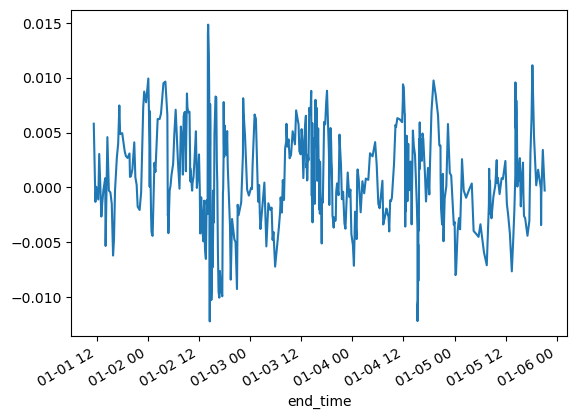

In [30]:
X2_y_pd.close.plot()

In [ ]:
X2_y_pd.ofi_signed_quote_sum.plot()

<Axes: xlabel='end_time'>

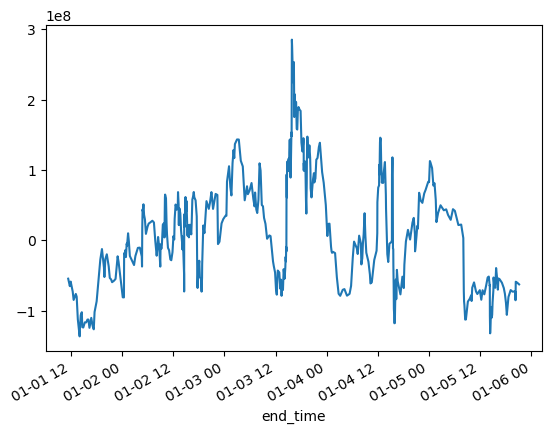

In [ ]:
# X2_y_pd.alt_frequency.hist(bins=100)
# X2_y_pd.ofi_signed_quote_sum.plot()
# X2_y_pd.ofi_trade_count_diff.plot()
X2_y_pd.ofi_signed_quote_sum.hist(bins = 100)

In [36]:
ofi_signed_quote_sum = X2_y_pd.ofi_signed_quote_sum
normal_window = range(3,30,3)

for window in normal_window:
    ofi_signed_quote_sum_mean = ta.MA(ofi_signed_quote_sum,window)
    ofi_signed_quote_sum_std = ta.STDDEV(ofi_signed_quote_sum,window)
    ofi_signed_quote_sum_norm = (ofi_signed_quote_sum - ofi_signed_quote_sum_mean) / ofi_trade_count_diff_std
    print('window {}, ic {}'.format(window, ofi_signed_quote_sum_norm.corr(X2_y_pd.close)))

# ofi_trade_count_diff_mean = ta.MA(ofi_trade_count_diff,5)
# ofi_trade_count_diff_std = ta.STDDEV(ofi_trade_count_diff,5)
# ofi_trade_count_diff_norm = (ofi_trade_count_diff - ofi_trade_count_diff_mean) / ofi_trade_count_diff_std
# # ofi_trade_count_diff_norm.plot()
# ofi_trade_count_diff_norm.hist(bins=100)
# ofi_trade_count_diff_norm.corr(X2_y_pd.close)

# X2_y_pd['ofi_trade_count_diff_norm'].corr(X2_y_pd.close)

window 3, ic -0.06486740907531828
window 6, ic -0.08850680288612224
window 9, ic -0.12058770066008533
window 12, ic -0.14163922061392223
window 15, ic -0.1417087116592538
window 18, ic -0.1195445062637074
window 21, ic -0.09583410798643965
window 24, ic -0.08369813147552053
window 27, ic -0.08573825059165785


In [ ]:


# # ic_decay = []
# ic_decay_list = []


# mask = dollar_bar.columns


# for i in dollar_bar.columns[dollar_bar.columns.str.contains('ret', case=False)]:
#     ic_decay_list.append(dollar_bar['high_freq_downside_ratio_norm'].corr(dollar_bar[i]))
# print(ic_decay_list)